# Hi, Slug!

Sorry it’s taken me so long to get back to you – work’s gotten crazy. Here’s a summary of what I’m working on:

**Neural Networks with Fast AI**
First, I’m leveraging Jeremy Howard and Rachel Thomas’s excellent deep learning library, FastAI. The library (built on top of PyTorch) implements a ton of “latest and greatest” techniques for dealing with rapidly creating and training neural networks. 

*Side note: if you haven’t come across them before, their tagline is “making neural nets uncool again”. From their site:  “Being cool is about being exclusive, and that’s the opposite of what we want. We want to make deep learning as accessible as possible– including to people using uncool languages like C#, uncool operating systems like Windows (which is used by the majority of the world), uncool datasets (way smaller than anything at Google, and in domain areas you’d consider obscure), and with uncool backgrounds (maybe you didn’t go to Stanford).”*


In [1]:
# Import the FastAI library and the tabular module.
from fastai import *
from fastai.tabular import *

# https://github.com/wesm/feather
import feather

# This will drop once I fix the built-in MSE calc in FastAI
from sklearn.metrics import mean_squared_error

In [2]:
# # Import ring files
# ring_X = pd.read_csv('data/ring_X.csv')
# ring_y = pd.read_csv('data/ring_Y.csv')

# # Combine X and Y
# ring_raw = pd.concat([ring_X, ring_y], axis=1, join='inner')

# # Feather ring files
# feather.write_dataframe(ring_raw, 'data/ring_raw')

I'll send you a separate email with a few questions I have on the columns of the data set, but I'll drop the EDA from this file.

## Pre-processing and creating the data bunch

In [3]:
# Read feather version of data into Pandas
ring_raw = feather.read_dataframe('data/ring_raw')

# Drop all zero value items. There are less than 200 and they screw with the training too much.
ring_raw = ring_raw[ring_raw['y'] != 0]

# Set the path to the data source
path = './data'

# Create a copy of the data frame under the name "df". I only do this because I'm lazy and can reuse code easier. 
df = ring_raw.copy()

# Set your dependant variable.
dep_var = 'y'

# Create two lists: one with low-cardinality columns (less than 50) and high-cardinality. The low ones get treated
# as categorical variables (given embedding matricies in the neural network) while the rest are treated as linear. 
# I'm working on a v2 where I go through each variable and see which would work better where, but for prototyping, 
# this is enough.
cat_vars = []
cont_vars = []

for i in list(ring_raw.columns):
    if df[i].nunique() < 50: cat_vars.append(i)
    else: 
        if i != dep_var: cont_vars.append(i)

# Set which pre-processing steps FastAI will handle.            
procs = [Normalize, Categorify, FillMissing]

# Creating 20% validation set. Here too I'm being lazy - future models should have a more thought out validation set
# that accuarately reflects the overall distribution.
valid_idx = range(len(ring_raw)-64900, len(ring_raw))

# Create the Data Bunch - automates the creation of the data loaders, does pre-processing, and comes with a few helper functions as well...
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, log=True) # Given the massive positive skew of the prices, we'll use the log of the target
                .databunch())

In [4]:
# ... suh as this one.
data.show_batch()

Curse Enemies with Level # Despair on Hit,+# Life gained for each Enemy hit by your Attacks,#% of Energy Shield Regenerated per second,+#% to all Elemental Resistances,Curse Enemies with Level # Frostbite on Hit,(pseudo) (total) Adds # Physical Damage to Attacks,Grants Level # Despair Skill,+# to Armour,#% faster start of Energy Shield Recharge,#% increased Strength,#% increased Area of Effect of Curse Skills,Gain #% of Physical Damage as Extra Fire Damage,#% increased Intelligence,+# Mana gained on Kill,Grants Level # Hatred Skill,Cannot be Ignited,#% increased Global Physical Damage,#% of Cold Damage Leeched as Life,#% increased Light Radius,Minions have #% increased Movement Speed,Wrath has #% increased Aura Effect,Grants Level # Aspect of the Cat Skill,Curse Enemies with Level # Vulnerability on Hit,#% increased maximum Energy Shield,Grants Level # Wrath Skill,Grants Level # Aspect of the Avian Skill,Hatred has #% increased Aura Effect,#% increased Damage,#% of Physical Attack Damage Leeched as Life,#% of Lightning Damage Leeched as Life,Anger has #% increased Aura Effect,Grace has #% increased Aura Effect,+# to Minimum Power Charges,Properties are doubled while in a Breach,edps,Item sells for much more to vendors,(pseudo) (total) +#% to Global Critical Strike Multiplier,Curse Enemies with Level # Flammability on Hit,+# Life gained on Kill,Determination has #% increased Aura Effect,-# to Total Mana Cost of Skills,(pseudo) (total) #% increased Chaos Spell Damage,#% of Physical Attack Damage Leeched as Mana,#% of Physical Damage Leeched as Life,Adds # to # Physical Damage to Attacks,Cannot roll Caster Modifiers,# to # Cold Damage per Frenzy Charge,Grants Level # Aspect of the Spider Skill,#% of Damage taken gained as Mana over 4 seconds when Hit,#% increased Global Accuracy Rating,Discipline has #% increased Aura Effect,(pseudo) (total) #% increased Cast Speed,Curse Enemies with Level # Conductivity on Hit,Grants Level # Anger Skill,+# Mana gained for each Enemy hit by your Attacks,#% increased Dexterity,+#% chance to Evade Attacks,Grants Level # Frostbite Skill,(pseudo) (total) #% increased Attack Speed,+# to Level of Socketed Gems,# Mana Regenerated per second,#% increased Effect of non-Damaging Ailments on Enemies,+# to Minimum Endurance Charges,#% chance when Hit for double Armour effect,#% increased Damage with Ailments,Cannot be Shocked or Ignited while moving,Cannot be Poisoned,#% increased Curse Duration,(pseudo) # Elemental Resistances,links,(pseudo) (total) #% increased Global Critical Strike Chance,#% increased maximum Mana,#% reduced Mana Cost of Skills,Grants Level # Aspect of the Crab Skill,#% of Chaos Damage Leeched as Life,#% of Fire Damage Leeched as Life,Grants Level # Flammability Skill,(pseudo) (total) #% increased Critical Strike Chance for Spells,#% increased Energy Shield from Body Armour,Suffixes Cannot Be Changed,#% increased Quantity of Items found,dps,Can have multiple Crafted Modifiers,Minions deal #% increased Damage,Grants Level # Conductivity Skill,Shock nearby Enemies for # Seconds when you Focus,+#% to Critical Strike Multiplier if you've Shattered an Enemy Recently,#% increased maximum Life,#% of Life Regenerated per second,#% increased Life Recovery from Flasks,+# to Minimum Frenzy Charges,#% increased Damage with Poison,(pseudo) (total) #% increased Lightning Damage with Attack Skills,(pseudo) (total) #% increased Fire Damage with Attack Skills,Adds # to # Fire Damage to Attacks,Adds # to # Cold Damage to Attacks,+# to Accuracy Rating,buyout_hits,corrupted,(pseudo) (total) #% increased Elemental Damage with Attack Skills,(pseudo) (total) +# to maximum Life,(pseudo) (total) +#% to Fire Resistance,(pseudo) (total) +#% to Lightning Resistance,(pseudo) (total) #% increased Fire Spell Damage,ilvl,(pseudo) (total) +#% to Chaos Resistance,(pseudo) (total) +# to maximum Mana,(pseudo) +#% total Elemental Resistance,(pseudo) (total) Adds # Fire Damage to Attacks,(pseudo) (total) +# to Dexterity,(pse

## Train the Model

In [5]:
# Define the RMSE function to be printed out after each epoch below.
def rmse(pred, targ):
    "RMSE between `pred` and `targ`."
    return torch.sqrt(((targ - pred)**2).mean())

In [6]:
# Creating a four-hidden-layer NN with 400, 200, 100, 50 perceptrons in each respective layer. I'm still playing with architecture, so 
# this will almost certianly change.
learn = tabular_learner(data, layers=[400,200,100,50], metrics=rmse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


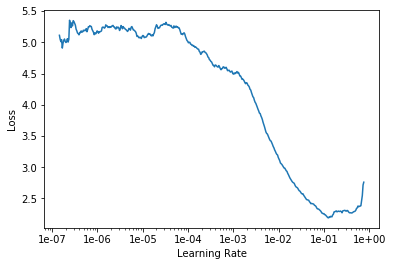

In [7]:
# There's a built-in tool in FastAI that helps identify the ideal learning rate. Generally, I use the LR one order of magnitude less tha the LR at the min loss.
# (looking like about 2e-2).
learn.lr_find(num_it=500);
learn.recorder.plot()

In [8]:
# Train the learer over 5 epochs using a one-cycle policy (origianl paper: https://arxiv.org/abs/1512.03385, great explination at:
# https://sgugger.github.io/the-1cycle-policy.html) with a maximum learning rate of .02 and a weight decay value of 0.1.
learn.fit(5, 2e-2, wd=0.1)

epoch,train_loss,valid_loss,rmse
1,1.682264,2.264273,1.912781
2,1.636734,4.306417,2.020808
3,1.577374,2.655945,1.730317
4,1.650120,2.506009,1.692205
5,1.665210,2.868882,1.855835


In [9]:
# Calculate final RSME.
x,y = learn.get_preds()
rmse_output=np.sqrt(mean_squared_error(y, torch.sigmoid(x)));
rmse_output

1.9472355

In [10]:
# Save the model
learn.save('for-slug')

In [11]:
# Create a copy of the validation set
temp = learn.get_preds()
preds = np.exp(temp[0].data).numpy().T[0]
valid_temp = df.iloc[valid_idx]

# Add the predictions to the data set
valid_temp['preds'] = preds

# Show slices of the data, focusing just on the pred vs. actuals. 
valid_temp.iloc[15:30,-2:]

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,y,preds
259324,25.0,39.457664
259325,25.0,34.288387
259326,25.0,65.573067
259327,25.0,25.540644
259328,10.0,2.545351
259329,1.0,2.218024
259330,1.0,1.956040
259331,30.0,5.102535
259332,400.0,13.152665
259333,30.0,9.676002


As you can see, there's some work still to do. My supposition is that the skew in values is still too hard for the model to reflect. I'm going to try a few things:

  * Dropping values more than 3 sigma from the mean (I think this will the model better in lower-value cases, but crap at higher values).
  * Creating three models - a classifier that groups values into above or below XX value (10c?), then two regression models for each value range.
  
I hope to send you the next version in a week or two. Please send any suggestions my way!